## Example : Magnetic probes

This example will show how to use the probes class.

First we need a tokamak and equilibrium, since the probes takes both as inputs and computes properties based on the equilibrium. We will just take the code from example_1 to generate a sample equilibrium. The only modification is to include the probe path which has the pickle file containing the probes information. 

Equilibrium data was not provided. Proceeded with default initialization.


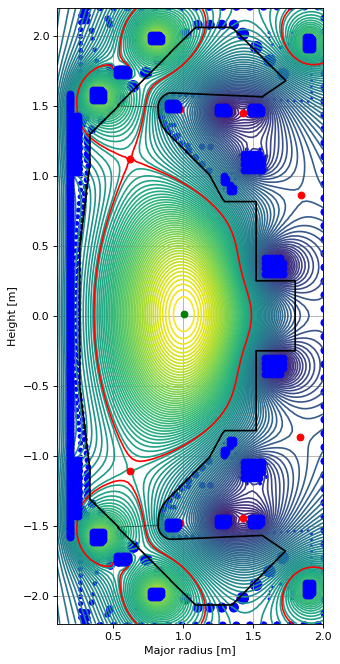

In [1]:
%load_ext autoreload
%autoreload 2 

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"
os.environ["PROBE_PATH"] = "../machine_configs/MAST-U/magnetic_probes.pickle"


# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

eq._updatePlasmaPsi(eq.plasma_psi)

# This plots the resulting equilibrium
fig = plt.figure(figsize=(5, 10), dpi=80);
ax = fig.add_subplot(111);
ax.grid(True,which='both');
eq.plot(axis=ax,show=False);
eq.tokamak.plot(axis=ax,show=False);

The tokamak object has a probe object attribute pre initialised, however if we wanted to we could create a stand alone one by importing `freegsnke.magnetic_probes$` and then setting up with `probes = magnetic_probes.Probe()`. In the tokamak the probes object is located in `tokamak.probes`. When it is initialised it reads the information on the names, positions and orientations of the different probes from the pickle file. 

Next we need to initialise the greens functions that are used in the calculations. This is done by running `tokamak.probes.initialise_setup(eq)`. This takes as an input an equilibrium object and saves probe attributes of greens functions for each current source (coils and plasma) and evaluated at the positions of the probes. The purpose of the equilibrium here is to provide the size/shape of the grid that is used when determining the plasma greens functions. 

In [2]:
# initialise setup of greens functions
tokamak.probes.initialise_setup(eq)

Once initialised we can also now access information on things like the names, position and number of different coils or probes.

In [3]:
# display some sample info - coil and probe names and positions.
# print first 5 for clarity of displaying
print(tokamak.probes.coil_names[:5])
print(tokamak.probes.floop_order[:5])
print(tokamak.probes.floop_pos[:5])
print(tokamak.probes.pickup_pos[:5])
print(tokamak.probes.pickup_or[:5])

['Solenoid', 'PX', 'D1', 'D2', 'D3']
['f_nu_01', 'f_nu_02', 'f_nu_03', 'f_nu_04', 'f_nu_a05']
[[0.901     1.3582   ]
 [0.9544    1.3041999]
 [1.0445    1.2150999]
 [1.1239    1.1366   ]
 [1.1505    1.1987   ]]
[[2.7689999e-01 3.0000000e+02 1.2620300e+00]
 [2.7689108e-01 2.9999680e+02 1.2245095e+00]
 [2.7689999e-01 3.0000000e+02 1.1870301e+00]
 [2.7689108e-01 2.9999680e+02 1.1495094e+00]
 [2.7689999e-01 3.0000000e+02 1.1120300e+00]]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


Now in principle we could update and resolve the equilibrium. Doing this will not require any changes to the probe object, assuming the machine setup doesn't change. Once we have the equilibrium we want to analyse with the probes, we can call the probe functions. There are two probe types implemented - flux loops and pickup coils which measure $\psi(r,z)$ and $\vec B(r,z)\cdot \hat n$ where $\hat n$ is the orientation vector of the pickup coil. The two functions are `calculate_fluxloop_value(eq)` and `calculate_pickup_value(eq)`, the outputs of which are arrays with probe values for each probe. 

If one is interested in certain probes, then `tokamak.probes.floop_order` and `tokamak.probes.pickup_order` contain a list of the probe names which can be used to find the appropriate element of the output list. Alternatively the could be combined into a dictionary.

In [4]:
# compute probes 
floops_vals = tokamak.probes.calculate_fluxloop_value(eq)
pickups_vals = tokamak.probes.calculate_pickup_value(eq)


# create dictionary to access specific 
dict = {}
for i, el in enumerate(tokamak.probes.floop_order):
    dict[el] = floops_vals[i]
print(dict)

{'f_nu_01': 0.015090961002505225, 'f_nu_02': 0.012700279258448507, 'f_nu_03': 0.009597883067762363, 'f_nu_04': 0.008072754673406644, 'f_nu_a05': 0.0011724952987647655, 'f_nu_b05': 0.0007005980597147507, 'f_nu_06': 0.007137752705509565, 'f_nl_01': 0.014330602265193977, 'f_nl_02': 0.011837142157782848, 'f_nl_03': 0.008539616782363271, 'f_nl_04': 0.006912883969162828, 'f_nl_a05': 0.00011943368361590906, 'f_nl_b05': -0.00034984286810001847, 'f_nl_06': 0.006316217012521164, 'f_p6u_01': 0.013449891946591568, 'f_p6l_01': 0.01200955004154184, 'f_bu_01': 0.0056071880370348395, 'f_bu_02': -0.01257705767046146, 'f_bu_03': -0.026826457050411798, 'f_bu_04': -0.02150444900459718, 'f_bl_01': 0.005551321375735566, 'f_bl_02': -0.012383844023496383, 'f_bl_03': -0.026466112113736576, 'f_bl_04': -0.02113357056574694, 'f_p5u_01': -0.012130922766785263, 'f_p5u_02': -0.016467892834140505, 'f_p5u_03': -0.014095952353618962, 'f_p5u_04': -0.005447270012745323, 'f_p5l_04': -0.007935484789620889, 'f_p5l_03': -0.0

Suppose we want to compute a new equilibrium with a different grid spacing or shape. We don't need to update the probe objects, we simply pass the new equilibrium to the 'calculate' functions. The first time a new grid is encountered it will create a new set of greens functions and save them to a dictionary so that they can be reused in the future if the same grid is used again. 

Below is a new equilibrium with a modified grid shape and spacing. When a new grid is encountered, a message is displayed to tell that new greens are computed. Note it only does it the first time.

Note that computing on a different grid but with same plasma setup should give the same values at the probes, which we do.

In [5]:
eq_new = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.0, Zmax=2.0,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq_new,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq_new)    

import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq_new.tokamak[key].current = current_values[key]

GSStaticSolver.solve(eq=eq_new, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

Equilibrium data was not provided. Proceeded with default initialization.


In [6]:
floops_vals_new = tokamak.probes.calculate_fluxloop_value(eq_new)

# compare values
print(floops_vals[:5])
print(floops_vals_new[:5])


new equilibrium grid - computed new greens functions
[0.01509096 0.01270028 0.00959788 0.00807275 0.0011725 ]
[0.01509156 0.01270099 0.0095988  0.00807391 0.00117359]


In [7]:
pickup_vals_new = tokamak.probes.calculate_pickup_value(eq_new)

new equilibrium grid - computed new greens functions


If we re-run this same line of code, we don't get the message that the greens functions have been recalculated. They are stored in a dictionary labeled by a key containing the grid specification in the form `key = (Rmin,Rmax,Zmin,Zmax,nx,ny)`.

In [8]:
pickup_vals_new2 = tokamak.probes.calculate_pickup_value(eq_new)

# show greens function keys
tokamak.probes.greens_B_plasma_oriented.keys()


dict_keys([(0.1, 2.0, -2.2, 2.2, 65, 129), (0.1, 2.0, -2.0, 2.0, 65, 129)])